In [1]:
import torch
import argparse
import torch.nn as nn
import torch.optim as optim
import time

from tqdm.auto import tqdm

/home/carlos/Documents/python/environments/pytorchenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sys import path
path.append('../src')

from data_loading import load_data
from cnn_model import build_cnn_model

### Hyperparameters

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 0
EPOCHS = 5
LEARNING_RATE = 1e-3

### Load data

In [4]:
train_loader, valid_loader, test_loader, class_names = load_data(img_size=IMG_SIZE, 
                                                  batch_size=BATCH_SIZE, 
                                                  num_workers=NUM_WORKERS, 
                                                  pin_memory=True
                                                  )

Path to chest x-ray dataset files: /home/carlos/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2
Path to NIH chest x-ray dataset files: /home/carlos/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3
Directory exists: /home/carlos/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray
Contents: ['test', 'train', 'val', '__MACOSX', 'chest_xray']
Directory exists: /home/carlos/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3
Contents: ['train_val_list.txt', 'images_003', 'LOG_CHESTXRAY.pdf', 'images_008', 'images_009', 'images_006', 'images_007', 'BBox_List_2017.csv', 'images_012', 'images_010', 'images_001', 'Data_Entry_2017.csv', 'images_005', 'ARXIV_V5_CHESTXRAY.pdf', 'images_004', 'README_CHESTXRAY.pdf', 'FAQ_CHESTXRAY.pdf', 'test_list.txt', 'images_011', 'images_002']
Kaggle classes: ['NORMAL', 'PNEUMONIA']
[NIH] Indexed 112,120 image files from 12 dirs.
NIH (official lists): tv=51376 test=10416 → train=46238

In [5]:
print(f"[INFO]: Number of training images: {len(train_loader.dataset)}")
print(f"[INFO]: Number of validation images: {len(valid_loader.dataset)}")
print(f"[INFO]: Number of testing images: {len(test_loader.dataset)}")
print(f"[INFO]: Class names: {class_names}\n")

[INFO]: Number of training images: 51454
[INFO]: Number of validation images: 5154
[INFO]: Number of testing images: 11040
[INFO]: Class names: ['NORMAL', 'PNEUMONIA']



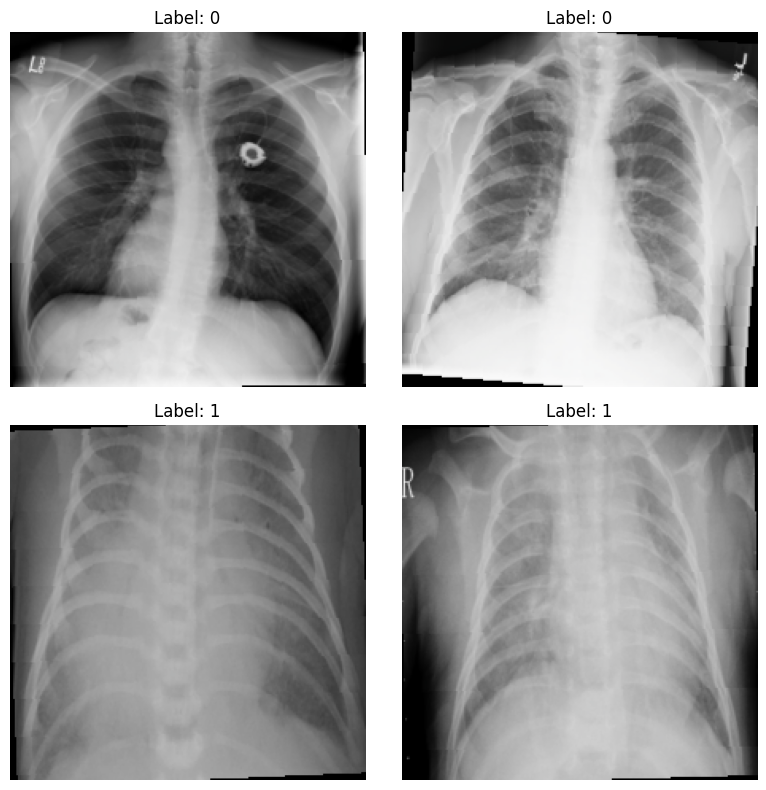

In [6]:
# Draw 4 samples from the train loader and display them in a 2x2 grid
import matplotlib.pyplot as plt
import numpy as np

batch = next(iter(train_loader))
if isinstance(batch, dict) and batch.get("is_cutmix", False):
    xb, yb = batch["images"], batch["targets"]
else:
    xb, yb = batch

images = xb[:4]
labels = yb[:4]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    img = images[i].cpu().numpy().transpose(1, 2, 0)
    # Undo normalization for display (ImageNet stats)
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')
plt.tight_layout()
plt.show()# DataLoaders

### Training

In [7]:
# Learning_parameters. 
lr = LEARNING_RATE
epochs = EPOCHS
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")
print(f"Learning rate: {lr}")
print(f"Epochs to train for: {epochs}\n")

Computation device: cuda
Learning rate: 0.001
Epochs to train for: 5



In [8]:
# Training function.
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

# Validation function.
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [9]:
model = build_cnn_model(
        pretrained=True,
        fine_tune=True, 
        num_classes=len(class_names)
    ).to(device)

[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...


In [10]:
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [11]:
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

4,010,110 total parameters.
4,010,110 training parameters.


In [12]:
# Optimizer.
optimizer = optim.Adam(model.parameters(), lr=lr)
# Loss function.
criterion = nn.CrossEntropyLoss()

In [13]:
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                                optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                    criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    time.sleep(5)

[INFO]: Epoch 1 of 5
Training


100%|██████████| 1608/1608 [08:30<00:00,  3.15it/s]


Validation


100%|██████████| 162/162 [00:58<00:00,  2.75it/s]


Training loss: 0.227, training acc: 90.710
Validation loss: 0.140, validation acc: 95.906
--------------------------------------------------
[INFO]: Epoch 2 of 5
Training


100%|██████████| 1608/1608 [08:49<00:00,  3.04it/s]


Validation


100%|██████████| 162/162 [00:58<00:00,  2.78it/s]


Training loss: 0.189, training acc: 92.407
Validation loss: 0.170, validation acc: 93.675
--------------------------------------------------
[INFO]: Epoch 3 of 5
Training


100%|██████████| 1608/1608 [08:29<00:00,  3.16it/s]


Validation


100%|██████████| 162/162 [00:58<00:00,  2.76it/s]


Training loss: 0.165, training acc: 93.241
Validation loss: 0.168, validation acc: 93.849
--------------------------------------------------
[INFO]: Epoch 4 of 5
Training


100%|██████████| 1608/1608 [08:37<00:00,  3.11it/s]


Validation


100%|██████████| 162/162 [00:58<00:00,  2.78it/s]


Training loss: 0.141, training acc: 94.133
Validation loss: 0.151, validation acc: 94.994
--------------------------------------------------
[INFO]: Epoch 5 of 5
Training


100%|██████████| 1608/1608 [08:27<00:00,  3.17it/s]


Validation


100%|██████████| 162/162 [00:58<00:00,  2.78it/s]


Training loss: 0.117, training acc: 95.330
Validation loss: 0.153, validation acc: 94.548
--------------------------------------------------


TRAINING COMPLETE


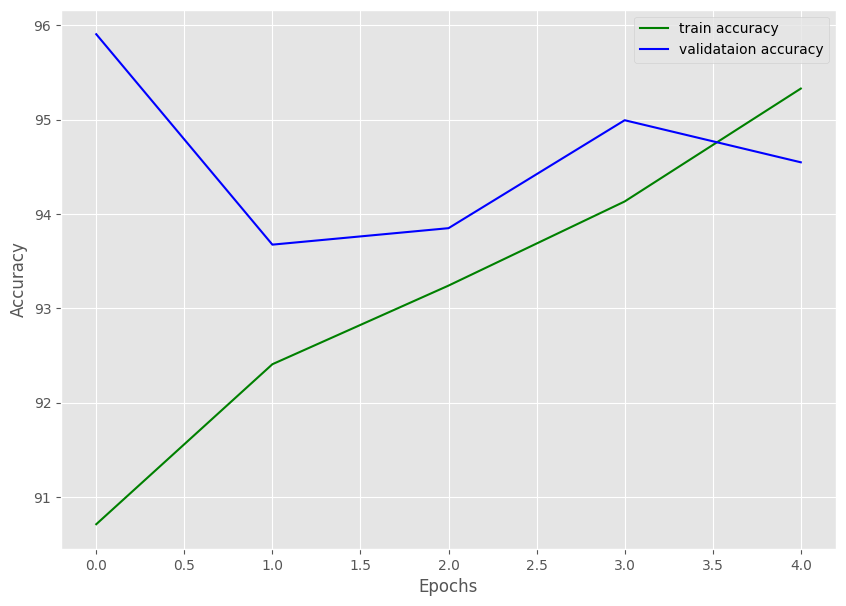

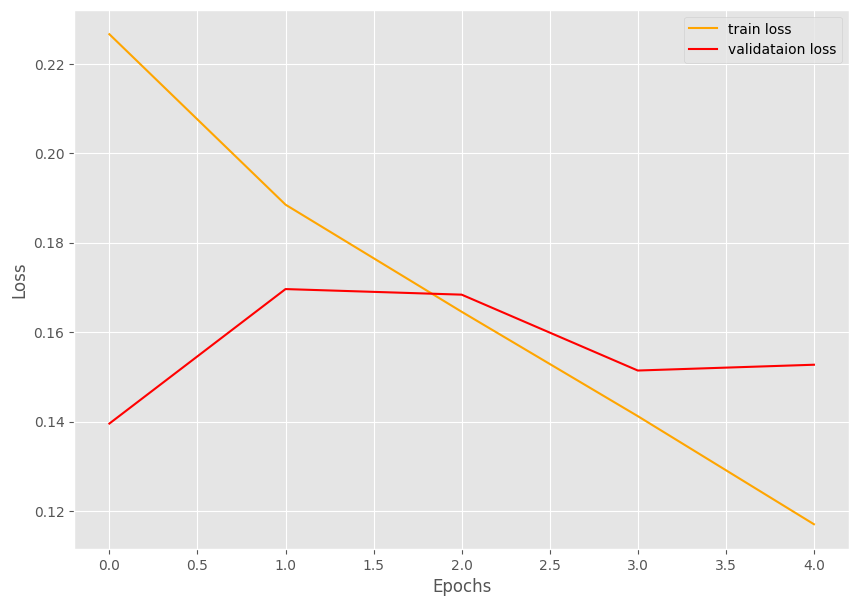

In [ ]:
from utils import save_model, save_plots

# Save the trained model weights.
save_model(epochs, model, "CNN", optimizer, criterion, True)
# Save the loss and accuracy plots.
save_plots(train_acc, valid_acc, train_loss, valid_loss, "CNN", True)
print('TRAINING COMPLETE')